# Debiasing with Propensity Score
 
Previously, we saw how to go from a biased dataset to one where the treatment looked as good as randomly assigned. We used orthogonalization for that. That technique was based on predicting the treatment and the outcome and then replacing both with their predictions' residuals. 
 
$
t^* = t - M_t(X)
$
 
$
y^* = y - M_y(X)
$
 
That alone is a powerful technique. It works both when the treatment is continuous or binary. Now, we'll take a look at another method which is based on the propensity score. Since the propensity score is best defined when the treatment is binary or categorical, this debiasing technique will also work only for categorical  or binary treatments. Still, in some situations, it can be more reliable than orthogonalization and it is very much worth learning. 
 
But first, we need to change context a little bit. We were talking about ice cream prices, which is a continuous treatment. Now, we will look into marketing emails, a binary treatment. And just as a side note, it is totally fair play to discretize a continuous treatment into buckets so it looks categorial (for example, you can take price, which is continuous, and discretize it in bins of R$ 2.00 like [2.00, 4.00, 6.00, 8.00]). Back to the emails now.
 
The situation goes like this. You work at a financial company (I'm not very creative with my examples, sorry) that supplies, not surprisingly, financial products such as life insurance, savings account, investment account and so on. The company is coming up with a new financial consulting service and wants to market it to its customers. To do so, the marketing team tried out three different emails: `em1`, `em2` and `em3`. 
 
Because the marketing team is very well educated in statistics and experimental design, they don't simply send the email to everyone and see what happend. Instead, they design an experiment where each customer has a probability of receiving the email. This probability is based on their business intuition to who will be more responsive to the email. For example, `em1` is targeted to a mass market audience, that don't invest much and that don't have a high income. These people will have a higher probability of receiving `em1`. Finally, after having defined that probability, we randomize the assignment so that customers receive the email according to their assigned probabilities.
 
![img](./data/img/debias-ps/ps-experiment.png)
 
As a side note, this is the best way I know of that uses business expertise to target an audience while still allowing you to make valid inference about how effective the marketing strategy is. The marketing team not only assigned the email according to this probability function, but they actually stored each customers' probability, which will be very handy later on. 
 
Here is what the data from this experiment looks like. We have data on four customer attributes: `age`, `income`, how much they have on life `insurance` and how much they have `invested`. These are the attributes which the marketing team used to assign the probability of receiving each email. Those probabilities are stored in columns `em1_ps`, `em2_ps` and `em3_ps`. Then, we have information on whether the customer actually received the email on columns `em1`, `em2` and `em3`. These are our treatment variables. Finally, we have the outcome, `converted`, flags if the customer contracted the financial advisory service.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
email = pd.read_csv("./data/invest_email.csv")
email.head()

,age,income,insurance,invested,em1_ps,em2_ps,em3_ps,em1,em2,em3,converted
0,44.1,4214.66,14036.41,7988.66,0.118507,0.045174,0.921281,0,0,1,1
1,39.8,1151.27,66622.15,1000.74,0.431123,0.005659,0.000000,1,0,0,0
2,49.0,8047.26,14119.53,29480.22,0.062137,0.166706,0.840049,0,0,1,0
3,39.7,10558.37,14798.26,36373.09,0.047372,0.205684,0.000000,0,0,0,0
4,35.3,802.15,780.84,1643.16,0.616450,0.009292,0.000000,1,0,0,0


As we can see, there are customers with very low probability of receiving `em1`. This is the case of customer 2, which has a probability of only 0.062. Also notice that this customer did not receive `em1`. This is not surprising, given that he had a very low probability of receiving this email. 
 
Now, contrast this with the following customers. All of them had a very high chance of getting `em1`, but none of them did.

In [3]:
email.query("em1 == 0").query("em1_ps>0.9")

,age,income,insurance,invested,em1_ps,em2_ps,em3_ps,em1,em2,em3,converted
2438,48.0,538.02,26276.38,1582.82,0.913562,0.008951,0.999208,0,0,1,1
2692,44.2,545.62,2377.01,743.40,0.901065,0.004204,0.999047,0,0,1,0
3152,44.6,541.42,13272.96,1455.92,0.907929,0.008233,0.999136,0,0,1,1
4175,38.0,543.20,16787.28,1302.20,0.905007,0.007364,0.000000,0,0,0,1


## Inverse Probability of Treatment Weighting
 
![img](./data/img/debias-ps/again.png)
 
Just to recap the idea behind propensity score debiasing (we've already seen it when we discussed propensity score), we are very interested in customers like the ones above. They look a lot like the ones that get `em1`, after all they had a high probability of getting that email. However, they didn't get it. This makes them awesome candidates to estimate the counterfactual outcome $Y_0|em1=1$. 
 
Propensity score debiasing works by encoding this intuitive importance we want to give to customers that look like the treated, but didn't get the treatment. It will also assign a high importance for those that look like the untreated, but got the treatment. The idea is pretty simple: just **weight every unit by the inverse probability of the treatment they got**. So, if a unit got the treatment, weigh it by $1/P(treatment=1)$. If a unit did not get the treatment, weigh it by $1/P(treatment=0)$ or $1/P(control)$. In the case of binary treatment, this is simply
 
$$
W_i = \dfrac{T}{P(T=1|X)} + \dfrac{1-T}{1-P(T=1|X)}
$$
 
For multiple treatments, we can generalize it to
 
$$
W_i = \sum^K_{k=0} \dfrac{\mathcal{1}_{K=k} }{P(T=k|X)}
$$
 
Now that we had an idea about how to use the propensity score to do debiasing, let's check how this works in practice. But first, let's see what happens when we don't debias our dataset.
 
Like I've said before, the treatment is confounded by the customer's characteristics: age, income, how much they have on insurance and how muc they have on hinvestment. 

In [4]:
confounders = ["age", "income", "insurance", "invested"]

If we look at their correlation structure, we can see that these variables are indeed confounders. They are correlated both with the treatment `em1` and the outcome `converted`. 


In [5]:
email[confounders + ["em1", "converted"]].corr()[["em1", "converted"]]

,em1,converted
age,-0.058796,0.401759
income,-0.305610,-0.054009
insurance,-0.023948,-0.076234
invested,-0.242374,-0.030250
em1,1.000000,0.046598
converted,0.046598,1.000000


If we fail to account for this confounding bias, our causal estimates will be wrong. To give an example, consider the `invested` variable. Those that invest **less** are **more** likely to convert **and** also **more** likely to receive the email. Hence, if we don't control for investments, it will look like `em1` increases the chance of conversion. But that could be just due to correlation, not causation, as lower levels of investments leads to both higher conversion and a higher chance of getting `em1`. 
 
Besides looking at the correlation with the confounders, we can also check how the distribution looks like for those that did and didn't get the email `em1`.

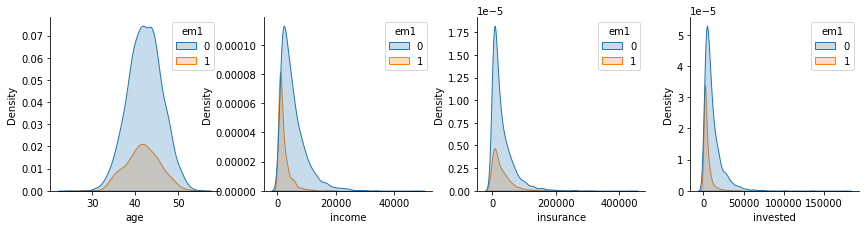

In [6]:
plt_df = pd.melt(email[confounders + ["em1"]], ["em1"], confounders)

g = sns.FacetGrid(plt_df, col="variable", hue="em1", col_wrap=4, sharey=False, sharex=False)

for i, ax in enumerate(g.axes):
    iter_df = plt_df.loc[lambda df: df["variable"] == confounders[i]]
    sns.kdeplot(x="value", hue="em1", data=iter_df, ax=ax, fill=True)
    ax.set_xlabel(confounders[i])

plt.show() 

 
### Stored Propensity Score
 
Now that we've confirmed that the assignment of `em1` is indeed biased, we can work on debiasing it with the propensity score. Now it's a good time to answer a question that might be in your head: why can't I just use orthogonalization? Or, more elegantly, when should I use the propensity score instead of orthogonalization. That's a good question and one I confess I don't have all the answers for. However, there is one clear case when there is a strong argument for the propensity score.
 
When you've stored the probabilities of receiving the treatment while conducting your experiment, **propensity score debiasing can be done without having to estimate a model**. If the assignment of the emails was done in a probabilistic way and we've stored those probabilities, then we don't have to rely on models. That's a huge advantage, because models are never perfect, which means that debiasing with them is also never perfect. Here, we have this situation where we've stored the probabilities of the treatments in the columns `em1_ps`, `em2_ps` and `em3_ps`. 
 
Since we are dealing only with `em1`, we only need the probability in `em1_ps` to do the debiasing. Here is what we'll do. First, we will generate the debiasing weights by using the formula we've seen above. Then, we will resample with replacement from this dataset, using the newly created weights. This means a unit with weight 2 will be resampled twice as often as a unit with weight 1. 

In [7]:
np.random.seed(123)
em1_rnd = email.assign(
    em1_w = email["em1"]/email["em1_ps"] + (1-email["em1"])/(1-email["em1_ps"])
).sample(10000, replace=True, weights="em1_w")

In [8]:
np.random.seed(5)
em1_rnd.sample(5)

,age,income,insurance,invested,em1_ps,em2_ps,em3_ps,em1,em2,em3,converted,em1_w
2252,44.0,5102.43,42300.28,2294.60,0.097928,0.012976,0.902465,0,0,1,0,1.108559
4364,44.0,8503.72,751.08,33314.37,0.058805,0.188387,0.830375,1,0,0,1,17.005333
752,44.4,1778.21,24615.45,3054.08,0.279973,0.017270,0.972922,1,0,1,1,3.571777
3656,39.8,1752.18,487.22,1893.95,0.284108,0.010710,0.000000,0,0,0,0,1.396859
4613,43.1,1023.04,64695.01,2220.32,0.484638,0.012556,0.988928,0,0,1,1,1.940382


This resampling should make a new dataset that is debiased. It should have oversampled units that looked like the treated (high `em1_ps`) but did not get the treatment and those that looked like the control (low `em1_ps`), but got the treatment. 
 
If we look at correlations between the treatment and the confounders, we can see that they essentially vanished.

In [9]:
em1_rnd[confounders + ["em1", "converted"]].corr()[["em1", "converted"]]

,em1,converted
age,-0.021004,0.404736
income,-0.026685,-0.037946
insurance,-0.037656,-0.071385
invested,-0.012073,-0.047987
em1,1.000000,0.076342
converted,0.076342,1.000000


Moreover, if we look at the confounders distributions by treatment assignment, we can see how nicely they align. This is not 100% proof that the debiasing worked, but it's good evidence of it. 

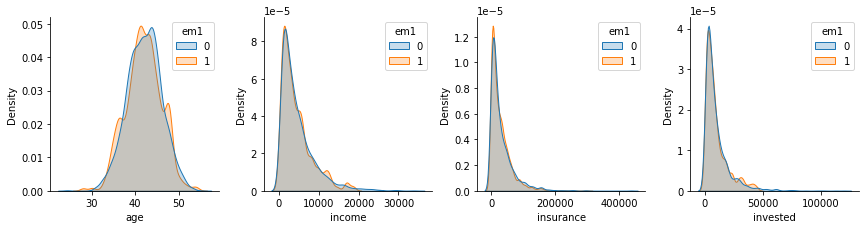

In [10]:
plt_df = pd.melt(em1_rnd[confounders + ["em1"]], ["em1"], confounders)

g = sns.FacetGrid(plt_df, col="variable", hue="em1", col_wrap=4, sharey=False, sharex=False)

for i, ax in enumerate(g.axes):
    iter_df = plt_df.loc[lambda df: df["variable"] == confounders[i]]
    sns.kdeplot(x="value", hue="em1", data=iter_df, ax=ax, fill=True)
    ax.set_xlabel(confounders[i])

plt.show() 

This new dataset we've created is now debiased. We can use it to do model evaluation or any other analys that requires the treatment to be randomly assigned. There is only one thing you need to watch out for. Notice how I've sampled 10000 points but the original dataset had only 5000? With this resampling method, I can make a debiased dataset as big as I wish. This means that confidence intervals that are computed in it are not valid, as they don't take into account the fact that the sample size can be artificially inflated. 
 
Ok, so this technique was super effective because we had the stored probabilities in the first place, but what if we don't? What if we only have access to the confounders and the treatment that got assigned, but not to how likely those units were to get the treatment?
 
### Estimated Propensity Score
 
If we don't have the propensity score stored, we will have to estimate them. In this situation, it becomes less clear when you should use propensity score or orthogonalisation for debiasing.
 
Since we don't have the propensity score, we will use a machine learning model to estimate it. The propensity score is closely related to the probability of treatment, so this ML model must be calibrated to output a probability. Not only that, we need to do cross prediction to work around any sort of bias we might have due to overfitting. 

In [11]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

t = "em1"

folds = 5

np.random.seed(123)

# makes calibrated Random Forest. 
m_t = CalibratedClassifierCV(
    RandomForestClassifier(n_estimators=100, min_samples_leaf=40, max_depth=3),
    cv=3
)

# estimate PS with cross prediction. 
ps_score_m1 = cross_val_predict(m_t, email[confounders], email[t],
                                cv=folds, method="predict_proba")[:, 1]

In [12]:
email.assign(ps_score_m1_est = ps_score_m1).head()

,age,income,insurance,invested,em1_ps,em2_ps,em3_ps,em1,em2,em3,converted,ps_score_m1_est
0,44.1,4214.66,14036.41,7988.66,0.118507,0.045174,0.921281,0,0,1,1,0.104727
1,39.8,1151.27,66622.15,1000.74,0.431123,0.005659,0.000000,1,0,0,0,0.389991
2,49.0,8047.26,14119.53,29480.22,0.062137,0.166706,0.840049,0,0,1,0,0.083805
3,39.7,10558.37,14798.26,36373.09,0.047372,0.205684,0.000000,0,0,0,0,0.086290
4,35.3,802.15,780.84,1643.16,0.616450,0.009292,0.000000,1,0,0,0,0.737111


Just out of curiosity, notice that the estimated propensity score, `ps_score_m1_est`, is close to the true one `em1_ps`, but not identical. Those errors in the estimation process will affect the final debiasing, but we hope it won't affect much. We can also check how well calibrated our score is. For that, we can plot the mean score against the mean `em1`. If the score is well calibrated, 20% of those with a score of 0.2 should have received email-1, 30% of those with a score of 0.3 should have received email-1 and so on.

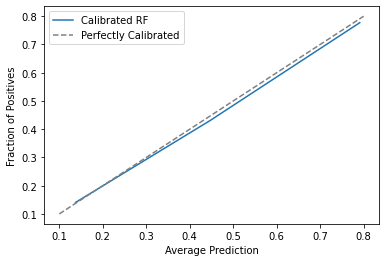

In [13]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(email["em1"], ps_score_m1, n_bins=3)
plt.plot(prob_pred, prob_true, label="Calibrated RF")
plt.plot([.1,.8], [.1, .8], color="grey", linestyle="dashed", label="Perfectly Calibrated")
plt.ylabel("Fraction of Positives")
plt.xlabel("Average Prediction")
plt.legend();

From here, we can proceed as if we had the true propensity score.


In [14]:
np.random.seed(123)
em1_rnd_est = email.assign(
    em1_w = email["em1"]/ps_score_m1 + (1-email["em1"])/(1-ps_score_m1)
).sample(10000, replace=True, weights="em1_w")

If we check the correlation structure, we will see that there are still some strong correlations between the treatment and the confounders, even after the debiasing process. For instance, income has a correlation of `-0.18` this is lower than the correlation in the unbiased dataset (`-0.3`), but much higher than what we got in the dataset that was debiased with the original propensity score (`0.01`). The same is true for the `invested` variable, which still shows some correlation. 

In [15]:
em1_rnd_est[confounders + ["em1"]].corr()["em1"]

age         -0.030409
income      -0.150937
insurance   -0.037893
invested    -0.111138
em1          1.000000
Name: em1, dtype: float64

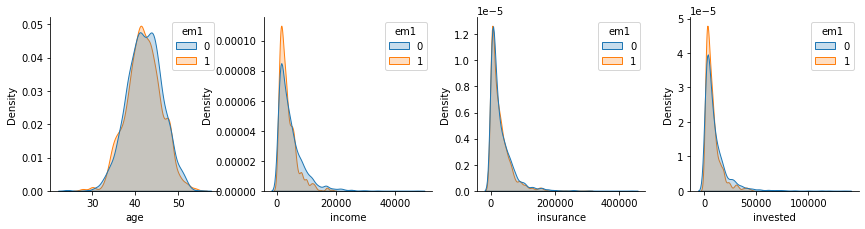

In [16]:
plt_df = pd.melt(em1_rnd_est[confounders + ["em1"]], ["em1"], confounders)

g = sns.FacetGrid(plt_df, col="variable", hue="em1", col_wrap=4, sharey=False, sharex=False)

for i, ax in enumerate(g.axes):
    iter_df = plt_df.loc[lambda df: df["variable"] == confounders[i]]
    sns.kdeplot(x="value", hue="em1", data=iter_df, ax=ax, fill=True)
    ax.set_xlabel(confounders[i])

plt.show() 

As for the distributions, we can see that they don't align that well as before, specially for the variables `invested` and `income`
 
## The Weakness of Propensity Score
 
We've already talked a lot about this on the propensity score chapter, so I won't spend much time on it, but it is recalling one of the main weaknesses with the propensity score debiasing. It has to do with propensities scores that are two high or too low. 

![img](./data/img/debias-ps/fear-no-man.png)
 
To understand this, take a look at the following unit in our original dataset.

In [17]:
email.loc[[1014]]

,age,income,insurance,invested,em1_ps,em2_ps,em3_ps,em1,em2,em3,converted
1014,43.2,18628.09,30356.68,28335.68,0.026862,0.160233,0.615788,1,0,0,1


This unit has a propensity score of 0.027 for `em1`. This means it's weight will be around 37 (1/0.027). This unit will be sampled almost twice as much as a treated unit with a propensity score of 0.05 (weight of 20), which is already a very low propensity score. This unit appears 38 times in the dataset we've resampled using the stored (not estimated) propensity score.

In [18]:
em1_rnd.loc[[1014]].shape

(38, 12)

That's a problem, because the debiased dataset is overpopulated with only one unit. If this unit wasn't in the original dataset, the debiased dataset could look totally different. So, removing a single unit can affect a lot how a debiased dataset looks like. This is a problem of high variance.
 
If we plot the number of replications for each unit in the debiased dataset, we see that a bunch of them appear more than 10 times. Those are treated units with low propensity score or untreated units with high propensity score. 

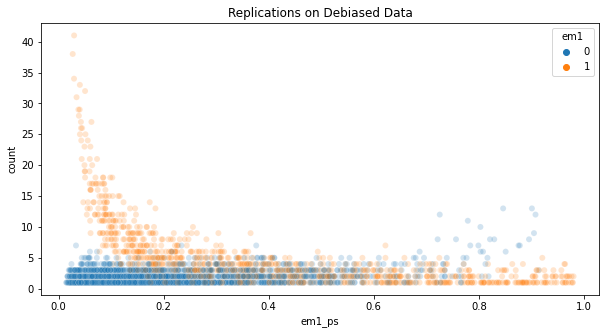

In [19]:
plt.figure(figsize=(10,5))
sns.scatterplot(
    data=em1_rnd.assign(count=1).groupby(em1_rnd.index).agg({"count":"count", "em1_ps": "mean", "em1": "mean"}),
    x="em1_ps",
    y="count",
    hue="em1",
    alpha=0.2
)
plt.title("Replications on Debiased Data");

To avoid having overly important units, some scientists like to clip the weights, forcing them to be, let's say, at most 20. It is true that this technique will remove some of the variance, but it will add bias back. Since the whole point of this was to remove bias, I feel like clipping the weights is not a good idea.
 
In my opinion, the best thing you can do is at the experimentation phase, not at the analysis phase. You should make sure none of the units have a weight that is too high. In other words, as much as possible, try to give the treatment with equal probabilities to everyone. 
 
To be fair to the propensity weighting method, all causal inference methods will suffer whenever the probability of receiving either the treatment or the control is too low, for the entire sample or for a subpopulation. Intuitively, this means some units will almost never receive the treatment or the control, which will make it difficult to estimate counterfactuals for those units. This problem can be seen as almost violating the common support assumption, which we will explore next. 

## Positivity or Common Support
 
Besides high variance, we can also have problems with positivity. Positivity, or common support is a causal inference assumption which states that there must be sufficient overlap between the characteristics of the treated and the control units. Or, in other words, that everyone has a non zero probability of getting the treatment or the control. If this doesn't happen, we won't be able to estimate a causal effect that is valid for the entire population, only for those we have common support.
 
To be clear, positivity issues are problems of the data itself, not a problem with the propensity score method. Propensity score method just makes it very clear when positivity problems exist. In that sense, this is an argument in favor of the propensity score. While most methods will not warn you when there are positivity problems, propensity score will show it to your face. All you have to do is plot the distribution of the propensity score for the treated and for the untreated.

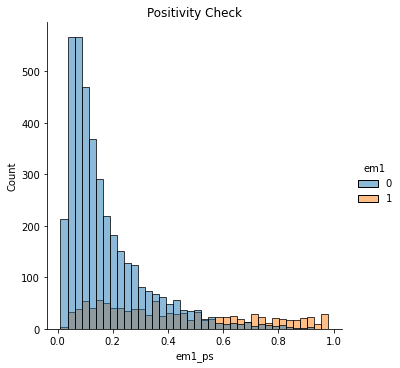

In [20]:
sns.displot(data=email, x="em1_ps", hue="em1")
plt.title("Positivity Check");

If they have a nice overlap, like in the plot above, then you have common support. 
 
Up until now, we've only looked at email-1 (`em1`). Let's look at email-3 now. 

In [21]:
email.head()

,age,income,insurance,invested,em1_ps,em2_ps,em3_ps,em1,em2,em3,converted
0,44.1,4214.66,14036.41,7988.66,0.118507,0.045174,0.921281,0,0,1,1
1,39.8,1151.27,66622.15,1000.74,0.431123,0.005659,0.000000,1,0,0,0
2,49.0,8047.26,14119.53,29480.22,0.062137,0.166706,0.840049,0,0,1,0
3,39.7,10558.37,14798.26,36373.09,0.047372,0.205684,0.000000,0,0,0,0
4,35.3,802.15,780.84,1643.16,0.616450,0.009292,0.000000,1,0,0,0


First thing that jumps the eye is that there are units with zero probability, which already indicates a violation to the positivity assumption. Now, let's look at the features distributions by `em3`

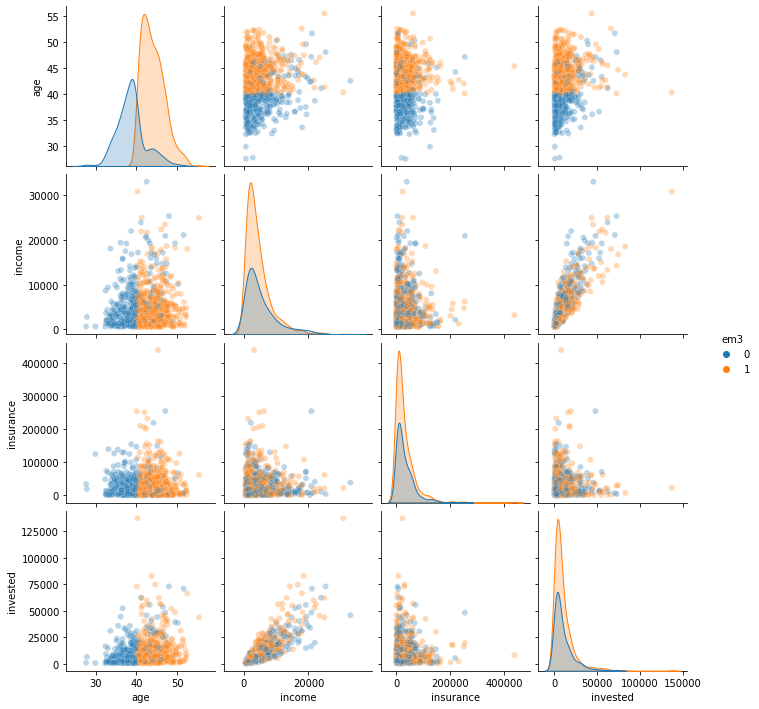

In [22]:
sns.pairplot(email.sample(1000)[confounders + ["em3"]], hue="em3", plot_kws=dict(alpha=0.3));

It looks like `em3` was only sent to customers that are older than 40 years. Thats a huge problem. If the control has younger folks, but the treatment doesn't, there is no way we can estimate the counterfactual $Y_0|T=1, age<40$. Simply because we have no idea how younger customers will respond to this email. 
 
Just so you know what will happen, we can try to make the propensity score debiasing.

In [23]:
em3_weight = (email
              # using a different implementation to avoid division by zero
              .assign(em3_w = np.where(email["em3"].astype(bool), 1/email["em3_ps"], 1/(1-email["em3_ps"])))
              .sample(10000, replace=True, weights="em3_w"))

In [24]:
em3_weight[confounders + ["em3"]].corr()["em3"]

age          0.251035
income       0.047607
insurance   -0.000961
invested     0.053524
em3          1.000000
Name: em3, dtype: float64

As we can see, there is still a huge correlation between age and the treatment. Not having treated samples that are younger than 40 years made it so that we couldn't remove the bias due to age.
 
We can also run the positivity diagnostic, plotting the propensity score distribution by treatment. 

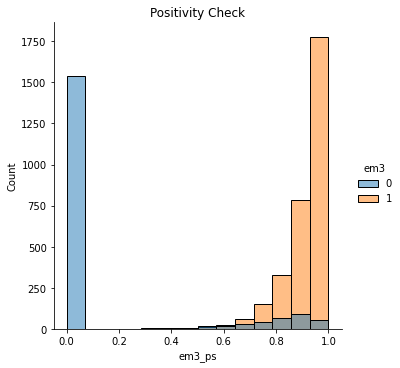

In [25]:
sns.displot(data=email, x="em3_ps", hue="em3")
plt.title("Positivity Check");

Notice how poor the overlap is here. Units with propensity score below 0.4 almost never get the treatment. Not to mention that huge peak at zero. 
 
### Positivity In Practice
 
Issues in positivity are very serious in the academic world because they treat the generalization of a conclusion or theory. If you only have treated individuals that are older, you have no way of generalizing whatever treatment effect that you find to a younger population. But in the industry, violations of the positivity assumption might not be so problematic. 
 
To give an example, if you are a lender wishing to estimate the elasticity of loan amount on probability of default, you will probably not give high loans to people with very low credit scores. Sure, this will violate the positivity assumption, but you are not very interested in estimating the loan amount elasticity for risky customers because you are not intending to give them loans anyway. Or, for a somewhat more exaggerated example, if you want to estimate the price elasticity of some product, you will probably not test prices from 0 to 1000000. That's because you have some intuition on where the prices normally are. You will often test around that region. 
 
The point here is that you can (and probably should) use your intuition to exclude some part of the population from receiving the treatment (or the control). Doing random experiments is expensive, so you should focus your efforts on where things are more promising. 
 
In our email example, probably the marketing team though that email-3 should never be sent to younger people. Maybe it contains text explicitly discussing something that only older people can relate to. Regardless of the reason, we can only estimate the effect of email-3 on the older, age>40, population. And that is totally fine. We just shouldn't expect to generalize whatever findings we have to the younger population.
 
With that in mind, let's debias email-3. Of course, we will remove the younger population from the sample. 

In [26]:
em3_weight.query("age>40")[confounders + ["em3"]].corr()["em3"]

age         -0.034455
income       0.024633
insurance   -0.005650
invested     0.020711
em3          1.000000
Name: em3, dtype: float64

Once we do that, notice how the correlation between the treatment and the confounders goes away. Remember that in the entire sample, the correlation with age was more than 0.2. Now, it is probably indistinguishable from zero.
 
We can also explore the distribution of treated and non treated in this filtered sample.

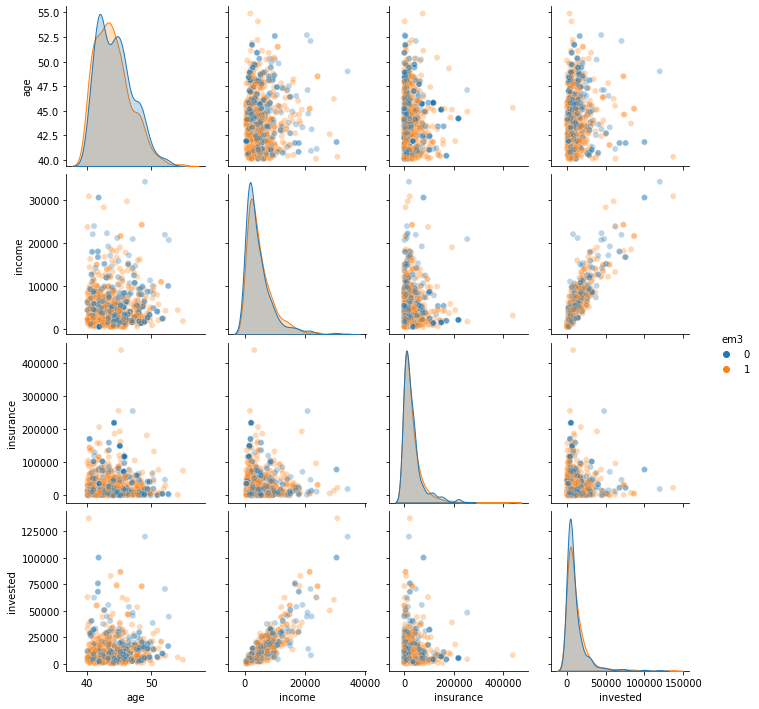

In [27]:
sns.pairplot(em3_weight.query("age>40").sample(1000)[confounders + ["em3"]], hue="em3", plot_kws=dict(alpha=0.3))

All of this to say that, yes, due to positivity violations, you can't debias the entire sample with respect to `em3`. But you can do it for the population for which email-3 was designed for in the first place. That is good enough.
 
## Key Ideas
 
This chapter presented another debiasing idea for when the treatment is binary or discrete. The idea is to resample the units using the inverse propensity score as a weight. This will upsample the units that look like the treated (high propensity score) but where not treated and those that look like the untreated (low propensity score) but where treated. 
 
The main advantage of propensity score debiasing is that it doesn't require estimating a model, if you've stored the probabilities of treatment during the experiment. This doesn't mean you can't apply propensity reweighting if you don't have those probabilities, but having to estimate them will add additional error to your debiasing process. 
 
As for the disadvantages, the propensity score reweighting can have a huge variance if the propensity score is either too high or too low, generating huge weights. Intuitively, this happens when there are very few untreated units that look like the treated and very few treated units that look like the untreated. To be fair to the propensity score weighting, this is a problem for all causal inference methods, but propensity weighting highlights this almost violation to the positivity assumption more clearly. 
 
Finally, we had a brief discussion about how much of a problem is violation in the positivity assumption. We ended up concluding that it is not a problem **as long as you don't wish to generalize your conclusions to the subset of the population where positivity doesn't hold**.
 
## References 
 
The things I've written here are mostly stuff from my head. I've learned them through experience. This means that they have **not** passed the academic scrutiny that good science often goes through. Instead, notice how I'm talking about things that work in practice, but I don't spend too much time explaining why that is the case. It's a sort of science from the streets, if you will. However, I am putting this up for public scrutiny, so, by all means, if you find something preposterous, open an issue and I'll address it to the best of my efforts.
 
Most of this chapter draws from Guido W. Imbens, Causal Inference for Statistics, Social, and Biomedical Sciences, where you will find extensive discussions on the propensity score. The discussion on positivity is on me though, from countless debates I had at work with my colleagues. 
 
## Contribute
 
Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).